# Data simulation

In this tutorial we demonstrate how to use RSMLM for simulation of dSTORM data. Lets start by loading the RSMLM package:

In [8]:
library(RSMLM)

## Simulating molecule coordinates

The first step in data simulation is the generation of ground truth for molecule/protein positions. We will simulate a simple dataset with four Gaussian clusters, two with a high molecule density and two with a low molecule density. We need to define some parameters for this simulation:

In [9]:
# standard deviation for the clusters (two low density and two high)
clusterSd <- c(20, 20, 5, 5)

# set the number of molecules per cluster
numMoleculesPerCluster  <- 50

# specify where each cluster should be centered. 
clusterPositionX <- c(100, 100, 200, 200)
clusterPositionY <- c(100, 200, 120, 180)

# limits for the field of view. This matrix defines the boundaries for our simulation area.
fieldLimits <- matrix(c(0, 300 , 0, 300), nrow = 2, ncol = 2)


Having defined these parameters we are ready to simulate the molecule positions:

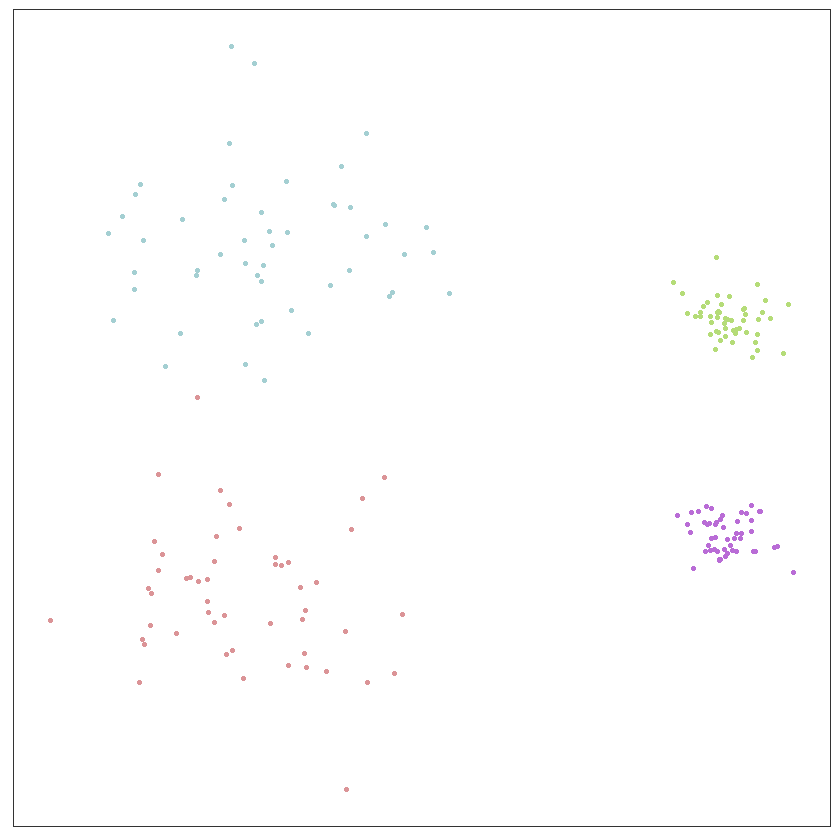

In [10]:
# retrieve the number of clusters from the length of the clusterSd vector
numClusters <- length(clusterSd)

# empty vectors to hold molecule coordinates
moleculePositionsX <- c()
moleculePositionsY <- c()
# to hold the cluster index for each molecule
moleculeClusterIndex <- c()

# generate Gaussian clusters at specified coordinates using a normal distribution
for (i in 1 : numClusters) {
    
    # add to existing vectors
    moleculePositionsX <- c(moleculePositionsX, rnorm(numMoleculesPerCluster, 
                            mean = clusterPositionX[i], sd = clusterSd[i]))
    moleculePositionsY <- c(moleculePositionsY, rnorm(numMoleculesPerCluster, 
                            mean = clusterPositionY[i], sd = clusterSd[i]))
    moleculeClusterIndex <- c(moleculeClusterIndex, rep(i, numMoleculesPerCluster))
}

# bind the two coordinate vectors together to get a matix containing the molecule coordinates
moleculeCoords <- cbind(moleculePositionsX, moleculePositionsY)

# plot a scatter plot of the molecule locations, coloured by cluster index
plotClusterScatter(moleculeCoords, moleculeClusterIndex)

## dSTORM simulation
After simulation of molecule positions we apply the dSTORM simulator provided by RSMLM. We must also specify the simulation parameters:

In [11]:
## Simulation parameters:

# mean number of fluophores attatched to each molecule
averageLabelsPerMol <- 5
# blinks per flurophore is based on geometic ditrubtion
blinkGeomProb <- 0.5
# precision varies per molecule based on lognormal distrubtion
# this gives the standard deviation of the normal distribution for detection position
# there is one value per dimension
precisionMeanLog <- c(2.8, 2.8)
precisionSdLog <- c(0.28, 0.28)
# for every blinking event what percentage are detected
detectionRate  <- 0.7
# percentage of false detections to add
falseDetectionRate <- 0.1

## Run the dSTORM simulator to get a detection list
detectionList <- simulateSTORM(moleculeCoords, averageLabelsPerMol, blinkGeomProb, precisionMeanLog,
                               precisionSdLog, detectionRate, falseDetectionRate, fieldLimits) 

numDetections <- dim(detectionList)[1]

print(paste(numDetections, 'detections were simulated'))



[1] "759 detections were simulated"


The key function here is simulateSTORM(). Given a list of molecule coordinates it performs a simulation of the dSTORM imaging process. It returns a data frame containing the coordinates ('x' and 'y') of each detection, and also the index linking each detection to a molecule ('moleculeIndex'). 

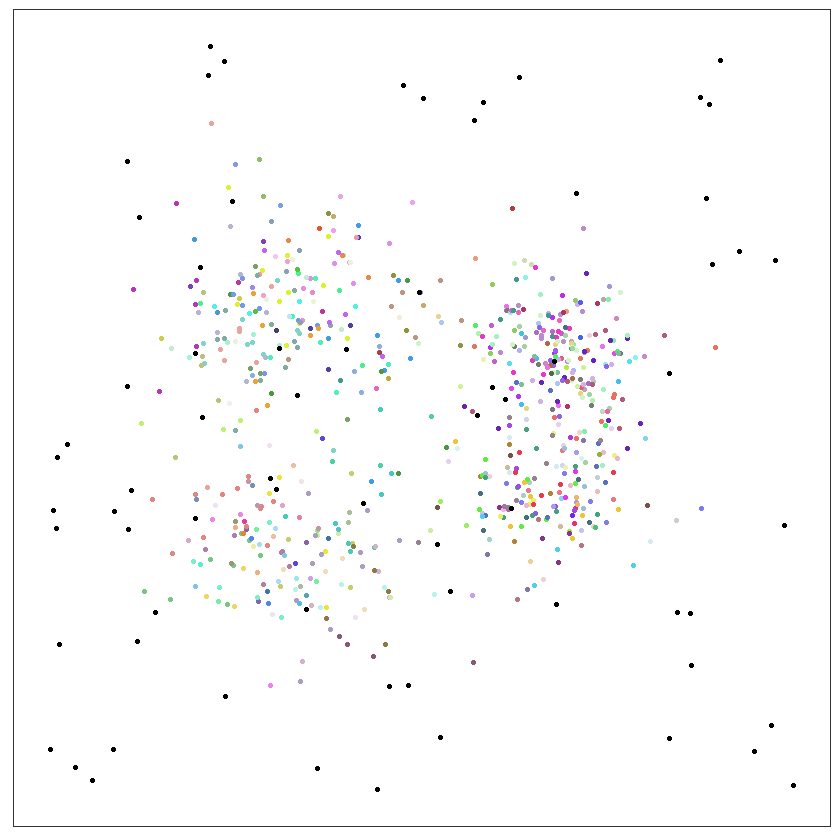

In [12]:
# call help() to get more information on a function
help(simulateSTORM)

# plot the results where detections are coloured based on molecule they originate from
plotClusterScatter(detectionList[ ,c('x', 'y')], detectionList$moleculeIndex)

For each detection we know which molecule it came from, and for every molecule we know which cluster it corresponds to. However if we want a vector linking detections directly to clusters we have a little work to do:

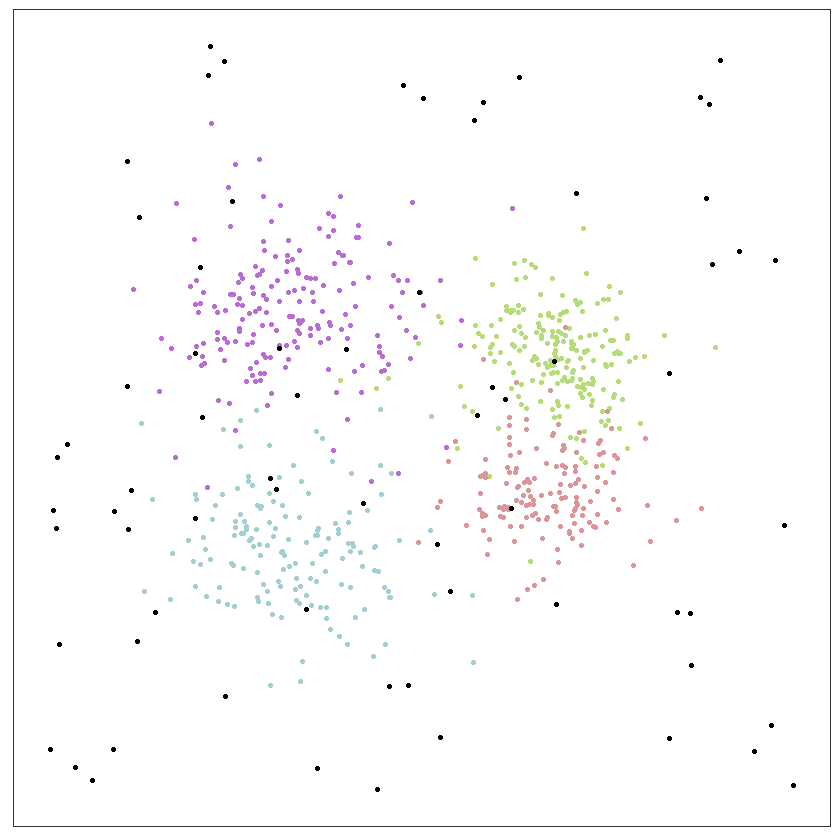

In [13]:
# vector to hold the cluster index for each detection                        
detectionClusterIndex <- rep(0, numDetections)

# find out which detections are noise (these will have a molecule index of zero)
noiseDetections <- detectionList$moleculeIndex == 0

# assign cluster indices to all detections which are not noise
detectionClusterIndex[!noiseDetections] <- moleculeClusterIndex[detectionList$moleculeIndex[!noiseDetections]]

# plot the results where detections are coloured by cluster
plotClusterScatter(detectionList[ ,c('x', 'y')], detectionClusterIndex)

## Exporting detection lists

Simulations can easily be exported as csv files. Here we append the cluster index for each detection before saving. This dataset will be loaded and used in the "Cluster analysis tutorial".

In [15]:
detectionList$clusterIndex <- detectionClusterIndex
write.csv(detectionList, file = '../data/detectionListSimpleClusters.csv')